In [1]:
import pandas as pd

In [2]:
import numpy as np


# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [105]:
df = pd.read_csv('C:/Users/Влад Чубенко/Downloads/RFM_ht_data.csv')

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [106]:
df

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


In [107]:
df.dtypes

InvoiceNo        object
CustomerCode     object
InvoiceDate      object
Amount          float64
dtype: object

In [108]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [109]:
df.dtypes

InvoiceNo               object
CustomerCode            object
InvoiceDate     datetime64[ns]
Amount                 float64
dtype: object

In [110]:
last_day = df['InvoiceDate'].max()

In [111]:
last_day

Timestamp('2020-09-30 00:00:00')

In [112]:
df['InvoiceNo'] = df['InvoiceNo'].apply(str)
df['CustomerCode'] = df['CustomerCode'].apply(str)

In [113]:
df.groupby('CustomerCode').agg({'InvoiceNo':'count'}).sort_values('InvoiceNo', ascending=False)

,InvoiceNo
CustomerCode,
19057820,204
13215452,113
13032521,106
19080880,99
99003061,90
...,...
13272861,1
13272871,1
13272875,1


In [114]:
rfmTable = df.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_day - x.max()).days,
                                           'InvoiceNo': lambda x: len(x),
                                           'Amount': lambda x: x.sum()})

In [115]:
rfmTable

,InvoiceDate,InvoiceNo,Amount
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88
...,...,...,...
99099927,10,1,961.10
99099936,0,1,1521.78
99099959,8,2,1444.56


In [116]:
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [117]:
rfmTable

,recency,frequency,monetary_value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88
...,...,...,...
99099927,10,1,961.10
99099936,0,1,1521.78
99099959,8,2,1444.56


In [118]:
rfmTable.frequency.max()

204

In [119]:
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])

In [120]:
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [121]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4

In [122]:
def FMClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.5]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]:
        return 2
    else:
        return 1

In [123]:
rfmSegmentation = rfmTable

In [124]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args = ('recency', quantiles))

In [125]:
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args = ('frequency', quantiles))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args = ('monetary_value', quantiles))
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)                             + rfmSegmentation.F_Quartile.map(str)                             + rfmSegmentation.M_Quartile.map(str)

In [126]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...
99099927,10,1,961.10,3,4,3,343
99099936,0,1,1521.78,1,4,3,143
99099959,8,2,1444.56,2,3,3,233


In [127]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...
99099927,10,1,961.10,3,4,3,343
99099936,0,1,1521.78,1,4,3,143
99099959,8,2,1444.56,2,3,3,233


In [128]:
rfmSegmentation.RFMClass.value_counts()

444    10624
111     9705
443     6729
344     6593
211     5847
       ...  
424       63
114       60
214       60
314       33
414        2
Name: RFMClass, Length: 64, dtype: int64

In [129]:
rfmSegmentation[rfmSegmentation['RFMClass']=='311']

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
10001834,13,6,5855.21,3,1,1,311
10001842,9,5,7219.98,3,1,1,311
10003108,9,5,6831.49,3,1,1,311
10003319,11,4,7588.12,3,1,1,311
10004583,9,11,13527.71,3,1,1,311
...,...,...,...,...,...,...,...
99089535,9,4,6394.49,3,1,1,311
99092052,11,4,6237.87,3,1,1,311
99093473,15,7,8483.54,3,1,1,311


In [130]:
rfmSegmentation.reset_index()

,CustomerCode,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,02213019,19,1,1609.20,4,4,3,443
1,02213042,22,3,9685.48,4,2,1,421
2,02213071,29,1,415.00,4,4,4,444
3,02213088,23,1,305.00,4,4,4,444
4,02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...,...
123728,99099927,10,1,961.10,3,4,3,343
123729,99099936,0,1,1521.78,1,4,3,143
123730,99099959,8,2,1444.56,2,3,3,233
123731,99099963,19,1,3018.91,4,4,2,442


In [132]:
rfmSegmentation.RFMClass.value_counts()

444    10624
111     9705
443     6729
344     6593
211     5847
       ...  
424       63
114       60
214       60
314       33
414        2
Name: RFMClass, Length: 64, dtype: int64

In [133]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


<AxesSubplot:xlabel='F_Quartile', ylabel='R_Quartile'>

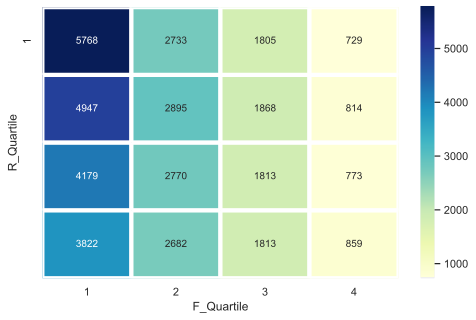

In [134]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4)